### Import useful libraries

In [49]:
%run "Imports.ipynb"

### Helpers

In [16]:
def divide_into_train_and_test(df,cut_date,timestamp):
    train = df[ df[timestamp] < cut_date ]
    test = df[ df[timestamp] >= cut_date ]    
    return train, test

In [63]:
def add_mixed_forecast(df,mean_supply_dict,cut_date):
    for name, group in df.groupby('zone'):  
        train, test = divide_into_train_and_test(group,cut_date,'timestamp')
        print(name)
        
        for r_idx, row in test.iterrows():
            if mean_supply_dict[name] > 0.5:            
                df.loc[r_idx, 'final_forecast'] =  df.loc[r_idx, 'prophet_forecast']
            else:
                df.loc[r_idx, 'final_forecast'] = df.loc[r_idx, 'forecast']
    return df   

In [25]:
def prepare_xyz(ResultDict):
    zone_results = pd.DataFrame.from_dict(ResultDict, orient='index')
    zone_results = zone_results.reset_index()
    first_column = zone_results.iloc[:, 0] 
    zone_results['x_coordinate'] = zone_results.apply (lambda row: row['index'][:1], axis=1)
    zone_results['y_coordinate'] = zone_results.apply (lambda row: row['index'][2:3], axis=1)
    return [zone_results['x_coordinate'],zone_results['y_coordinate'],zone_results[0]]

In [26]:
def plot_heatmap(x,y,z,cmap='coolwarm'):
    df = pd.DataFrame.from_dict(np.array([x,y,z]).T)
    df.columns = ['X_coordinate','Y_coordinate','max_supply']
    df['max_supply'] = pd.to_numeric(df['max_supply'])

    pivotted= df.pivot('X_coordinate','Y_coordinate','max_supply')
    pivotted
    plt.figure(figsize=(12, 9))
    sns.heatmap(pivotted,annot=True,cmap=cmap)

### Load data

In [45]:
data = pd.read_pickle("data_with_metrics.pkl")

### Analyze where Prophet performs better than naive prediction

In [57]:
mean_xyz = prepare_xyz(mean_supply_dict)

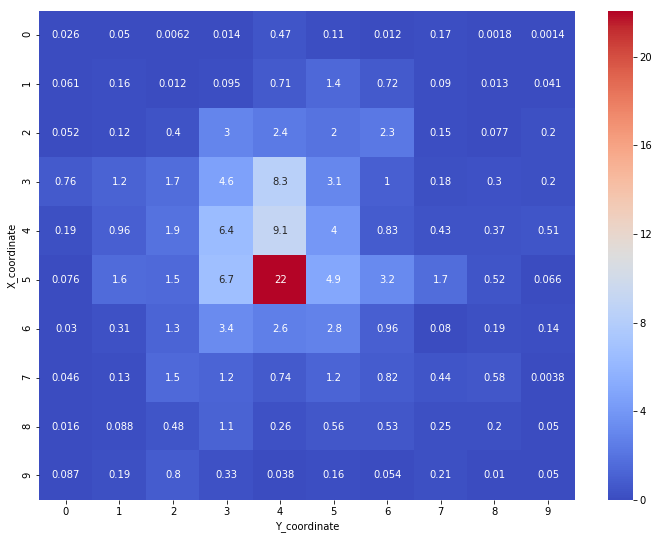

In [58]:
plot_heatmap(*mean_xyz)

In [59]:
max_xyz = prepare_xyz(max_supply_dict)

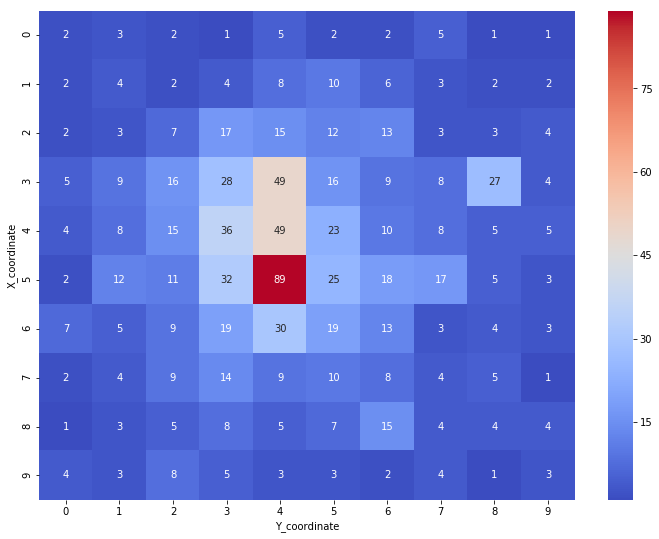

In [60]:
plot_heatmap(*max_xyz)

In [61]:
mean_improvement_xyz = prepare_xyz(mean_improvement_dict)

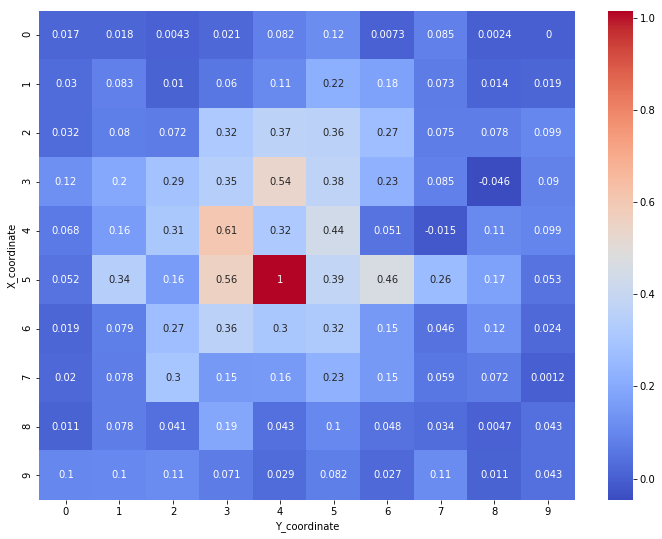

In [62]:
plot_heatmap(*mean_improvement_xyz)

In [63]:
sum_improvement_xyz = prepare_xyz(sum_improvement_dict)

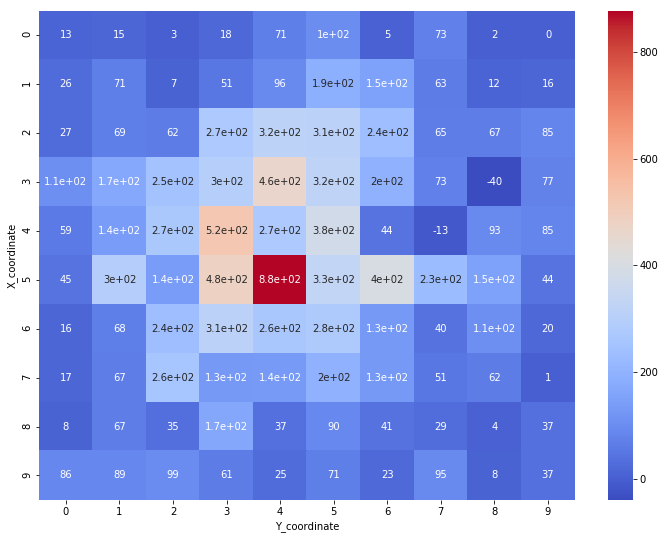

In [64]:
plot_heatmap(*sum_improvement_xyz)

### Calculate mixed prediction

In [65]:
# data = add_mixed_forecast(data,mean_supply_dict,'2019-12-31 00:00:00')

In [66]:
data.head()

,zone,timestamp,supply,forecast,date,hour,prophet_forecast,zone_mean_supply,zone_max_supply,zones_mean_improvement,zones_sum_improvement,final_forecast
0,0_0_10_10,2019-01-04 14:00:00,1,0.0,2019-01-04,14:00:00,NaN,0.026127,2,0.016905,13.0,NaN
1,0_0_10_10,2019-01-04 15:00:00,0,0.0,2019-01-04,15:00:00,NaN,0.026127,2,0.016905,13.0,NaN
2,0_0_10_10,2019-01-04 16:00:00,0,0.0,2019-01-04,16:00:00,NaN,0.026127,2,0.016905,13.0,NaN
3,0_0_10_10,2019-01-04 17:00:00,0,0.0,2019-01-04,17:00:00,NaN,0.026127,2,0.016905,13.0,NaN
4,0_0_10_10,2019-01-04 18:00:00,0,0.0,2019-01-04,18:00:00,NaN,0.026127,2,0.016905,13.0,NaN


In [67]:
# data.to_pickle("data_with_metrics_and_mixed_forecast.pkl")

In [68]:
data = pd.read_pickle("data_with_metrics_and_mixed_forecast.pkl")

In [69]:
data.head()

,zone,timestamp,supply,forecast,date,hour,prophet_forecast,zone_mean_supply,zone_max_supply,zones_mean_improvement,zones_sum_improvement,final_forecast
0,0_0_10_10,2019-01-04 14:00:00,1,0.0,2019-01-04,14:00:00,NaN,0.026127,2,0.016905,13.0,NaN
1,0_0_10_10,2019-01-04 15:00:00,0,0.0,2019-01-04,15:00:00,NaN,0.026127,2,0.016905,13.0,NaN
2,0_0_10_10,2019-01-04 16:00:00,0,0.0,2019-01-04,16:00:00,NaN,0.026127,2,0.016905,13.0,NaN
3,0_0_10_10,2019-01-04 17:00:00,0,0.0,2019-01-04,17:00:00,NaN,0.026127,2,0.016905,13.0,NaN
4,0_0_10_10,2019-01-04 18:00:00,0,0.0,2019-01-04,18:00:00,NaN,0.026127,2,0.016905,13.0,NaN


### Divide into train and test

In [71]:
train, test = divide_into_train_and_test(data,'2019-12-31 00:00:00','timestamp')

### Calculate success metrics for each approach

In [72]:
# 1. Dla każdej strefy liczymy średnią podaż. Rozumiem że to jest liczone dla każdej strefy osobno:

#      Strefa A Strefa B
# czas 1  1      15   
# czas 2  0      10
# czas 3  2      5

# średnia podaż dla strefy A to. śr_A = (1+0+2)/3 = 1
# średnia podaż dla strefy B to. śr_B = (15+10+5)/3 = 10
# Średnie wyliczam na podstawie treningowego zbioru danych.

# 2. Liczymy błąd dla każdej obserwacji (bezwzględna różnica między prognozą modelu i rzeczywistą podażą).
# Np. w godzinie ‘czas 4’ mam:
# dla strefy A błąd 2
# dla strefy B błąd 5

# 3. Dzielimy błąd dla każdej obserwacji przez średnią podaż wyliczoną wcześniej dla odpowiadającej jej strefy (względny błąd).
# W godzinie ‘czas 4’:
# dla strefy A błąd względny to 2/1 = 1,
# dla strefy B błąd względny to 5/10 = 0.5

# 4. Liczymy średnią błędów w danej godzinie, dla wszystkich stref.
# W godzinie ‘czas 4’:
# średnia4 = 1 + 0.5 = 0.75

# 5. Powtarzamy kroki 2,3,4 dla wszystkich godzin w zbiorze testowym.

# 6. Mamy średnie błędów względnych ze wszystkich stref wyliczone dla wszystkich godzin ze zbioru testowego 
# ([średnia4, średnia5,...]). 97 percentyl z tych wyników traktujemy jako nasz ostateczny rezultat

In [74]:
# 1. Dla każdej strefy liczymy średnią podaż (na podstawie zbioru treningowego).

# Średnia podaż dla każdej strefy została wyliczona wyżej, i dodana do analizowanego zbioru danych
# mean_supply_dict = calculate_zones_mean_supply(train)
# data['zone_mean_supply'] = data['zone'].map(mean_supply_dict)
mean_supply_dict

In [75]:
# 2. Liczymy błąd dla każdej obserwacji (bezwzględna różnica między prognozą modelu i rzeczywistą podażą).
test['errors_naive'] = abs(test['supply'] - test['forecast'])
test['errors_prophet'] = abs(test['supply'] - test['prophet_forecast']).round(0)
test['errors_mixed'] = abs(test['supply'] - test['final_forecast']).round(0)

In [76]:
# 3. Dzielimy błąd dla każdej obserwacji przez średnią podaż wyliczoną wcześniej dla odpowiadającej jej strefy (względny błąd).
test['relative_errors_naive'] = test['errors_naive'] / test['zone_mean_supply'] 
test['relative_errors_prophet'] = test['errors_prophet'] / test['zone_mean_supply'] 
test['relative_errors_mixed'] = test['errors_mixed'] / test['zone_mean_supply'] 

In [77]:
# 4. Liczymy średnią błędów w danej godzinie, dla wszystkich stref.
results_naive = []
results_prophet = []
results_mixed = []

# Prognoza naiwna
for name, group in test.groupby('timestamp'):
    # ~100 rows, one for each zone
    
    single_naive_result = group['relative_errors_naive'].mean()
    results_naive.append(single_naive_result)
    
    single_prophet_result = group['relative_errors_prophet'].mean()
    results_prophet.append(single_prophet_result)    
    
    single_mixed_result = group['relative_errors_mixed'].mean()
    results_mixed.append(single_mixed_result)    

print(np.percentile(results_naive, 97))
print(np.percentile(results_prophet, 97))
print(np.percentile(results_mixed, 97))

3.0132086220057666
2.0742013817694
2.8912070369536877
